In [1]:
import torch
import numpy
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
import seaborn as sns

import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = datasets.load_boston()
X = torch.tensor(data['data'], dtype=torch.float32)
y = torch.tensor(data['target'], dtype=torch.float32)
N, F = X.shape

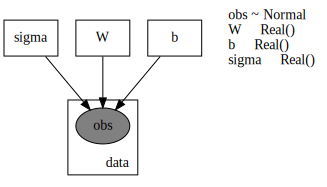

In [4]:
class FrequentistModel(pyro.nn.PyroModule):
    
    def __init__(self):
        super().__init__()
        self.W = pyro.nn.PyroParam(torch.randn(F))
        self.b = pyro.nn.PyroParam(torch.ones(1))
        self.sigma = pyro.nn.PyroParam(torch.ones(1), constraint=constraints.positive)

    def forward(self, X, y=None):
        mean = X @ self.W + self.b

        with pyro.plate("data", len(X)):
            return pyro.sample("obs", dist.Normal(mean, self.sigma), obs=y)

model = FrequentistModel()
pyro.render_model(model, model_args=(X, y), render_distributions=True, render_params=True)

In [5]:
for i in range(3):
    print(model(X)[:5])

tensor([-763.4691, -738.7316, -729.1083, -729.5688, -735.0287],
       grad_fn=<SliceBackward0>)
tensor([-765.8664, -738.4012, -728.2946, -729.5199, -733.8570],
       grad_fn=<SliceBackward0>)
tensor([-765.0601, -737.8345, -727.7272, -728.1514, -735.2600],
       grad_fn=<SliceBackward0>)


In [6]:
dist.Normal(0, 1).expand([F]).sample()

tensor([ 1.2005, -0.0439,  1.4343, -0.6747, -1.6388,  0.3133, -0.7136, -0.4157,
         0.3672,  0.2405,  0.5180,  1.1792, -0.5441])

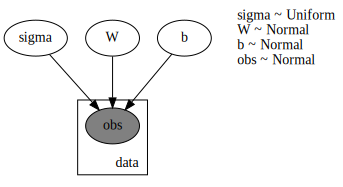

In [7]:
class BayesianModel(pyro.nn.PyroModule):
    
    def __init__(self):
        super().__init__()
        self.W = pyro.nn.PyroSample(dist.Normal(0, 10).expand([F]).to_event(1))
        self.b = pyro.nn.PyroSample(dist.Normal(20, 10))
        self.sigma = pyro.nn.PyroSample(dist.Uniform(0, 10))

    def forward(self, X, y=None):
        sigma = self.sigma   
        mean = X @ self.W + self.b
        
        with pyro.plate("data", N):
            return pyro.sample("obs", dist.Normal(mean, sigma), obs=y)

model = BayesianModel()
pyro.render_model(model, model_args=(X, y), render_distributions=True, render_params=True)

In [8]:
guide = pyro.infer.autoguide.AutoMultivariateNormal(model)

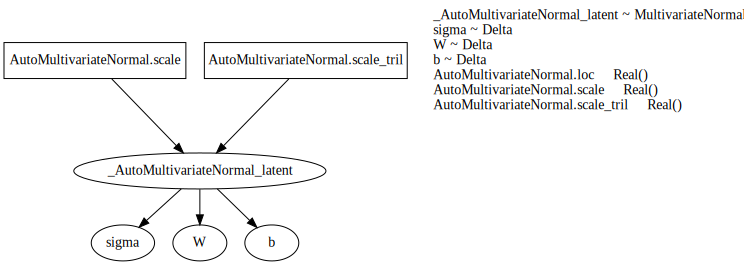

In [9]:
pyro.render_model(guide, model_args=(X, y), render_distributions=True, render_params=True)

In [10]:
def plot_losses(losses):
    plt.plot(losses)
    plt.title(f'Min loss: {min(losses)}')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

In [11]:
guide = pyro.infer.autoguide.AutoMultivariateNormal(model)
adam = pyro.optim.Adam({"lr": 0.02})  
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, guide, adam, elbo)

losses = []
for i in range(10_000):
    loss = svi.step(X, y)
    losses.append(loss)

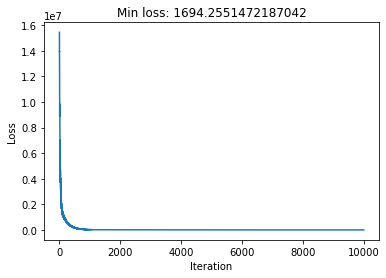

In [12]:
plot_losses(losses)

In [13]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

W [ 0.84852844 -1.3861849   0.39084554 -1.1681135  -0.6652957  -0.74628145
 -0.18241663 -0.14720514  0.41596487 -0.0511926  -0.23556314 -1.7784996
  0.08145105]
b [1.]
sigma [1.]
AutoMultivariateNormal.loc [ 1.9153361e+00 -9.1251574e-02  6.2170126e-02 -4.0329304e-03
  2.7933302e+00 -7.0205326e+00  4.1872091e+00  1.2966737e-03
 -1.0379241e+00  2.4751002e-01 -1.2231514e-02 -6.7929494e-01
  1.0759097e-02 -5.2162194e-01  2.0588373e+01]
AutoMultivariateNormal.scale [0.09137114 0.0559552  0.02263938 0.0802094  1.4306375  1.6961015
 0.16679573 0.02656453 0.13362326 0.05836359 0.00899199 0.08852936
 0.01044526 0.04401023 0.48264116]
AutoMultivariateNormal.scale_tril [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-7.88489636e-03  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 

In [14]:
with pyro.plate('samples', 1_000, dim=-1):
    samples = guide(X)

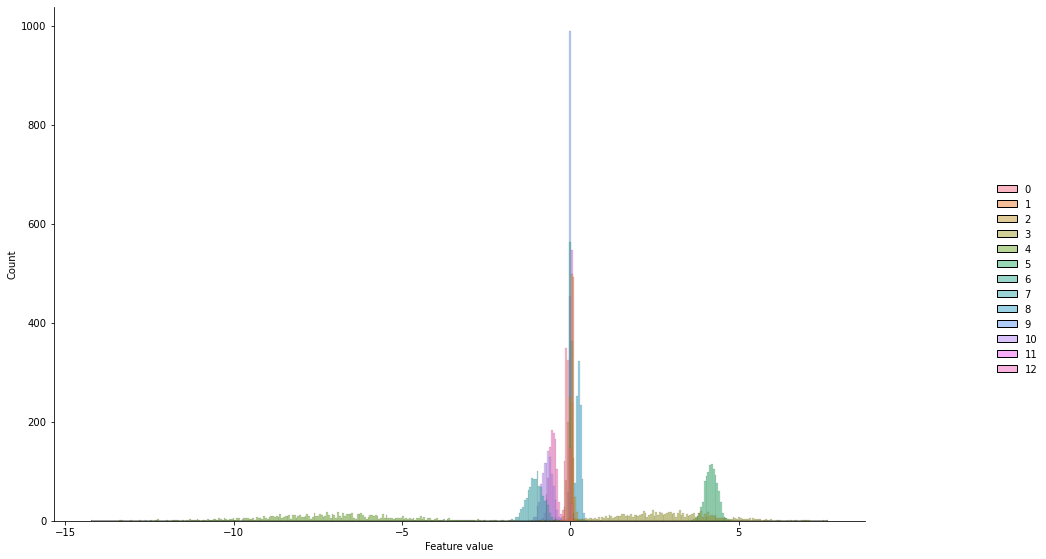

In [15]:
g = sns.displot(samples['W'].detach().numpy())
g.fig.set_figheight(8)
g.fig.set_figwidth(16)
plt.xlabel('Feature value');

In [16]:
predictive = pyro.infer.Predictive(model, guide=guide, num_samples=1_000)
svi_samples = predictive(X)
svi_y = svi_samples["obs"]

In [17]:
model.eval()
trace = torch.jit.trace(model, X)

In [18]:
print(trace.code)

def forward(self,
    X: Tensor) -> Tensor:
  rand = torch.rand(annotate(List[int], []), dtype=6, layout=None, device=torch.device("cpu"), pin_memory=False)
  _0 = torch.mul(rand, torch.sub(CONSTANTS.c0, CONSTANTS.c1))
  _1 = torch.add(CONSTANTS.c1, _0)
  _2 = torch.zeros([13], dtype=6, layout=None, device=torch.device("cpu"), pin_memory=False)
  _3 = torch.ones([13], dtype=6, layout=None, device=torch.device("cpu"), pin_memory=False)
  eps = torch.normal(_2, _3)
  _4 = torch.add(CONSTANTS.c3, torch.mul(eps, CONSTANTS.c2))
  _5 = torch.matmul(X, _4)
  _6 = torch.zeros(annotate(List[int], []), dtype=6, layout=None, device=torch.device("cpu"), pin_memory=False)
  _7 = torch.ones(annotate(List[int], []), dtype=6, layout=None, device=torch.device("cpu"), pin_memory=False)
  eps0 = torch.normal(_6, _7)
  _8 = torch.add(CONSTANTS.c4, torch.mul(eps0, CONSTANTS.c0))
  _9 = torch.add(_5, _8)
  subsample = torch.arange(506, dtype=None, layout=0, device=torch.device("cpu"), pin_memory=False)
  _1

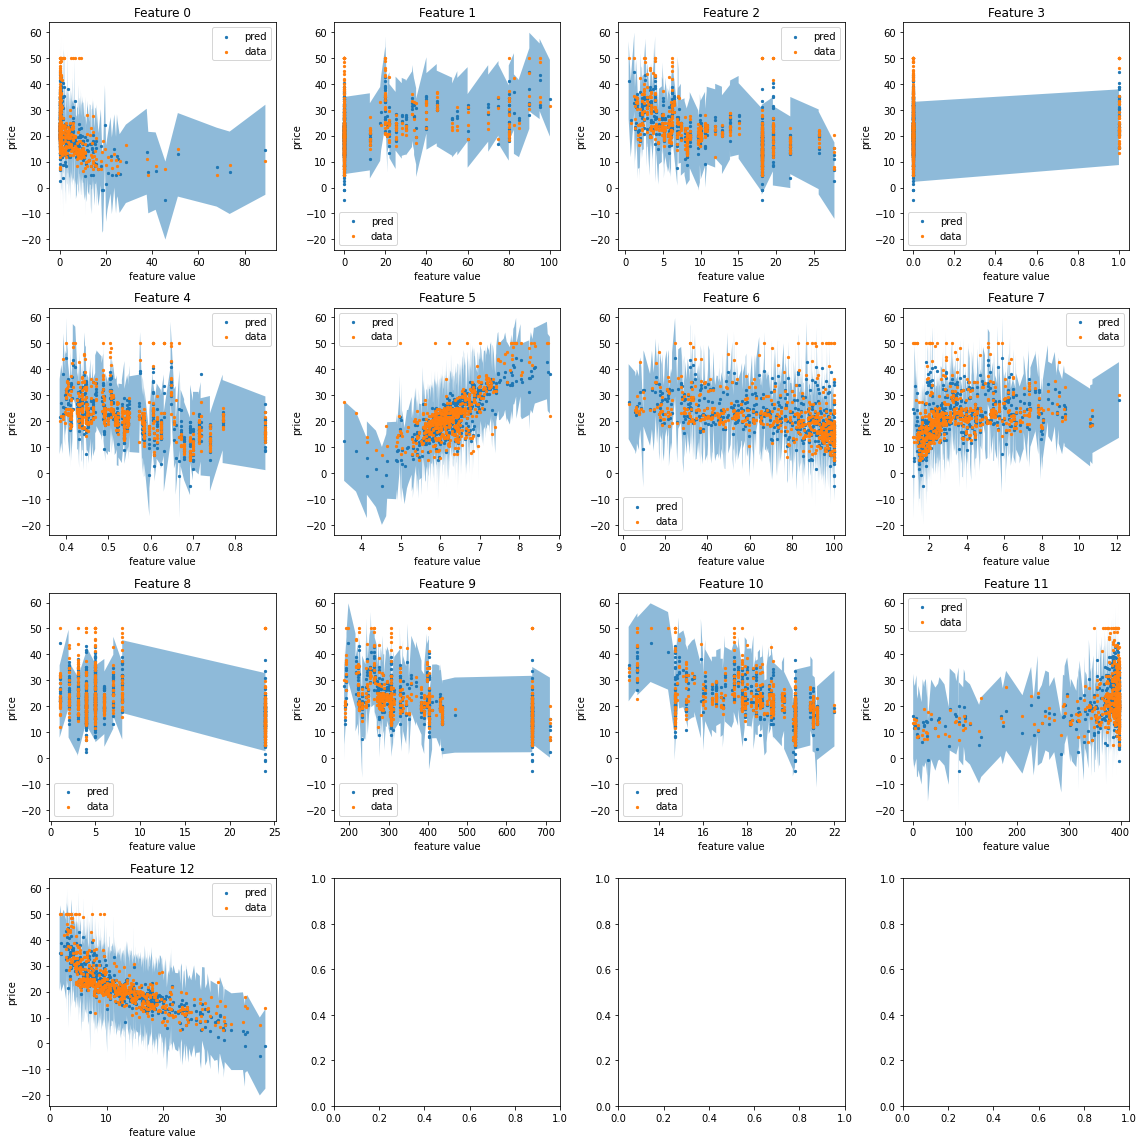

In [21]:
fig, axes = plt.subplots(4, 4, figsize=(16,16))
for i in range(F):
    preds = pd.DataFrame({
        'X': X[:, i],
        'y_mean': svi_y.mean(0).detach().cpu().numpy(),
        'y_perc_5': svi_y.kthvalue(int(len(svi_y) * 0.05), dim=0)[0].detach().numpy(),
        'y_perc_95': svi_y.kthvalue(int(len(svi_y) * 0.95), dim=0)[0].detach().numpy(),
        'true_y': y,
    }).sort_values('X')
    ax = axes[i // 4][i % 4]
    ax.scatter(preds['X'], preds['y_mean'], s=5, label='pred', c='C0')
    ax.fill_between(preds['X'], preds['y_perc_5'], preds['y_perc_95'], alpha=0.5)
    ax.scatter(preds['X'], preds['true_y'], s=5, label='data', c='C1')
    ax.set_title(f'Feature {i}')
    ax.set_ylabel('price')
    ax.set_xlabel('feature value')
    ax.legend()
plt.tight_layout()